# Restricted Boltzmann Machines in R

RBM training and testing algorithms, coded in plain R.

Here you can find a Restricted Boltzmann Machines, implemented in R and in plain algorithm, for academic and educational purposes.

@author Josep Ll. Berral (Barcelona Supercomputing Center)

Inspired by the implementations from:
* David Buchaca   : https://github.com/davidbp/connectionist
* Andrew Landgraf : https://www.r-bloggers.com/restricted-boltzmann-machines-in-r/
* Graham Taylor   : http://www.uoguelph.ca/~gwtaylor/

Author of the snippet to load the MNIST example:
* Brendan O'Connor https://gist.github.com/39760 - anyall.org

Mocap data

* R converted version: TODO - Here goes link to mnist.rds
* Data originally from Yann LeCun's MNIST digit recognition dataset [MNIST Database](http://yann.lecun.com/exdb/mnist/)

## GENERIC FUNCTIONS

We use these functions for initializing matrices (we will initialize the weights matrix with random values), to do Bernoulli sampling when deciding the activation of the hidden layers, and to pass values through a sigmoid function (also when producing the activation outputs).

* **sample_normal** : Generates a matrix of random normal values
* **sample_bernoulli** : Generates a matrix of Bernoulli samples given a matrix of probabilities
* **sigmoid_func** : Performs the sigmoid calculus over a matrix
* **%+%** : Operator to sum a vector to a matrix by their coincident side (row checked before columm)

In [1]:
## Function to produce Normal Samples
sample_normal <- function(dims, mean = 0, sd = 1)
{
    array(rnorm(n = prod(dims), mean = mean, sd = sd), dims);
}

## Function to produce Bernoulli Samples
sample_bernoulli <- function(mat)
{
    dims <- dim(mat);
    array(rbinom(n = prod(dims), size = 1, prob = c(mat)), dims);
}

## Function to produce the Sigmoid
sigmoid_func <- function(mat)
{
    1 / (1 + exp(-mat));
}

## Operator to add dimension-wise vectors to matrices
`%+%` <- function(mat, vec)
{
    retval <- NULL;
    tryCatch(
        expr = { retval <- if (dim(mat)[1] == length(vec)) t(t(mat) + vec) else mat + vec; },
        warning = function(w) { print(paste("WARNING: ", w, sep = "")); },
        error = function(e) { print(paste("ERROR: Cannot sum mat and vec", e, sep = "\n")); }
    );
    retval;
}

## RBM Functions

Functions for creating and operating RBMs:

* **create_rbm**: The constructor function
* **sample_h_given_v_rbm**: Activation function given input
* **sample_v_given_h_rbm**: Reconstruction function given activations
* **get_cost_updates_rbm**: One step of Contrastive Divergence (CD-k) process updating the CRBM

### Constructor of the RBM

This is the **constructor** of the RBM. This will initialize the RBM with random and blank values, or with introduced parameters. If we want to create a new RBM, we skip passing parameters to have a brand new initialized RBM. If we want to reassemble a former RBM from its weights matrices and bias vectors, we pass them as parameters.

The principal elements of the RBM are:
* **W** : The weight matrix between Visble Input and Hidden Units
* **hbias** : The hidden bias.
* **vbias** : The visible bias.

The RBM produces Hidden Unit activations from Visible Inputs through $(vis \cdot W + hbias)$, and reconstructs the Visible Units from Hidden activations through $(hid \cdot W^{T} + vbias)$. This way, Visible Inputs go through the "network" producing activations, and activations can be passed back through the "network" to reconstruct the Inputs. The difference between real Inputs and reconstructed Inputs are the _error_ or _loss_.

#### Dimension and purpose of Matrices

The matrix **W**, and vectors **hbias** and **vbias** will be initialized as random or just blank, and modified using the **Gradient Descent** technique with to the obtained loss at each iteration.

Input comes from Visible Units (the input has _nvis_ features at time _t_), so **Input** is a matrix $1 \times nvis$. As we can put data in batches, the **Input** becomes $batch\_size \times nvis$.

The Output (the hidden units) will be then a matrix with the number of hidden units for each element of the batch. So **Activations** will be a matrix $batch\_size \times nhid$.

Then, **W** transforms **Input** into **Activations**, so **W** is a matrix shaped as $nvis \times nhid$. Not to say that transposing **W** will allow us to transform **Activations** into **Inputs**.

Summary of Matrices:
* **Input** : $batch\_size \times nvis$
* **W** : $nvis \times nhid$
* **Activations** : $batch\_size \times nhid$

#### Dimension of bias Vectors

Further, when obtaining the **Activations**, we should add the bias for each feature in the obtained activation. Then **hbias** has to be a vector of size $nhid$. R allows us to add a vector repeatedly to all the rows of a matrix. If we couldn't, **hbias** should become a matrix of the same vector, repeated $batch\_size$ times.

The same happens when reconstructing the **Input** from **Activations**. A **vbias** vector, of size $nvis$ must be added to the resulting reconstruction.

In [2]:
## Restricted Boltzmann Machine (RBM). Constructor
create_rbm <- function (n_visible = 10, n_hidden = 100, W = NULL, hbias = NULL,
                        vbias = NULL, batch_size = 100)
{
    if (is.null(W)) W <- 0.01 * sample_normal(c(n_visible, n_hidden));
    if (is.null(hbias)) hbias <- rep(0, n_hidden);
    if (is.null(vbias)) vbias <- rep(0, n_visible);
    
    velocity <- list(W = array(0, dim(W)), v = rep(0, length(vbias)), h = rep(0, length(hbias)));
    
    list(n_visible = n_visible, n_hidden = n_hidden, W = W, hbias = hbias,
         vbias = vbias, velocity = velocity, batch_size = batch_size);
}

### Forward and Backward Functions

The next couple of functions implement the generation of hidden unit activations given visible values, and reconstruction of visible values from hidden activations. The learning process will use these functions to pass visible values forward and backward, to check the loss and gradients of the activation-reconstruction process.

#### Forwarding Inputs to Hidden Units

As said before, activation (or forwarding) is done by passing inputs towards the hidden units. The transformation is done using **Input** through **W** (and **hbias**), obtaining **Activations**.

$$pre\_activations = input \cdot W + hbias$$

In order to correctly produce the activations, we should pass them through a sigmoid function [TODO - Explain details and reasoning for this step].

$$mean\_activations = sigmoid(pre\_activations)$$

And finally, instead of having for each unit its mean of activations, we may generate a sample of "fully activated" and "fully deactivated" hidden units, by performing a bernoully sampling. This way, each $mean\_activation$ is used as the probability of whether the hidden unit is activated or not. The result is a fully binarized activations, conditioned to the probability of each unit to become activated or not (the "expected activation" that we obtained through the "mean activation").

$$sample\_activations = bernoully(mean\_activations)$$

#### Backwarding Activations to Visible Units

When we have the activations for a given batch of input data, we can perform the reconstruction (backward) process, by passing the activations towards the input data. The transformation is done using **Activations** through **t(W)** (and **vbias**), obtaining **~Input**.

$$mean\_reconstruction = activation \cdot W^{T} + vbias$$

Also, we don't need any sampling here, as we are deciding that:

$$sample\_reconstruction = mean\_reconstruction$$

In [3]:
### This function infers state of hidden units given visible units
visible_state_to_hidden_probabilities <- function(rbm, visible_state)
{
    h.mean <- sigmoid_func((visible_state %*% rbm$W) %+% rbm$hbias);
    h.sample <- sample_bernoulli(h.mean);

    list(mean = h.mean, sample = h.sample);
}

## This function infers state of visible units given hidden units
hidden_state_to_visible_probabilities <- function(rbm, hidden_state)
{
    v.mean <- (hidden_state %*% t(rbm$W)) %+% rbm$vbias;
    v.sample <- v.mean;

    list(mean = v.mean, sample = v.sample);
}

### Iterate over inputs to get Cost and Gradients

The "forward - backward" process must be done iteratively, in order to see how our matrix **W** (also bias vectors **hbias** and **vbias**) degrade our input after repeated "activation - reconstruction" processes. This is done using the **Contrastive Divergence** method, where we perform this process $k$ times, and then we compute the **Gradient Descent**.

#### Obtaining the Gradients
The process performs a **positive phase**, where a forward is performed. Then we iterate "backward - forward" (**negative phase**) $k$ times.

The key elements at the end of the process are:
* The Input, as the data we want to reconstruct
* The "Positive" Activations, as the activations we get directly, before iterating.
* The "Negative" Activations, as the final activations we obtain after iterating.
* The "Negative" Reconstruction, as the final values we obtain when reconstructing the input from the last activation.

Gradients are computed for each Matrix, as follows:
* **grad_W** : $\Delta W = input^{T} \cdot (positive)mean\_activation - (negative)mean\_reconstruction^{T} \cdot (negative)mean\_activation$
* **grad_vbias** : $\Delta vbias = colSum(input \cdot (negative)mean\_reconstruction)$
* **grad_hbias** : $\Delta hbias = colSum((positive)mean\_activation \cdot (negative)mean\_activation)$

Remember that all deltas must be scaled by the **learning rate**, and the **batch size**. Also, we can decide whether to add an **inertia** factor (or **momentum**), by storing the gradient and using it in the next iteration within a certain weight. Finally, we add the gradients to our matrices and vectors.

#### Reconstruction Error (Cost)

Computing the reconstruction error allows us to know how well our training is improving epoch after epoch. Here we compute the **cost** as

$$cost = \frac{\sum_{i = 1}^{ncols} \sum_{j = 1}^{nrows} (input - (negative)mean\_reconstruction)^2}{ncols}$$

or what is the same, the mean error between the inputs and the last reconstruction.

In [4]:
## This functions implements one step of CD-k
##  param input: matrix input from batch data (n_seq x n_vis)
##  param lr: learning rate used to train the RBM
##  param k: number of Gibbs steps to do in CD-k
##  param momentum: value for momentum coefficient on learning
cdk_rbm <- function(rbm, input, lr, k = 1, momentum = 0.1)
{  
    # compute positive phase (awake)
    ph <- visible_state_to_hidden_probabilities(rbm, input);

    # perform negative phase (asleep)
    nh <- ph;
    for (i in 1:k)
    {
        nv <- hidden_state_to_visible_probabilities(rbm, nh[["sample"]]);
        nh <- visible_state_to_hidden_probabilities(rbm, nv[["sample"]]);
    }

    # determine gradients on RBM parameters
    Delta_W <- t(input) %*% ph[["mean"]] - t(nv[["sample"]]) %*% nh[["mean"]];
    Delta_v <- colSums(input - nv[["sample"]]);
    Delta_h <- colSums(ph[["mean"]] - nh[["mean"]]);
    
    rbm$velocity[["W"]] <- rbm$velocity[["W"]] * momentum + lr * Delta_W / rbm$batch_size;
    rbm$velocity[["v"]] <- rbm$velocity[["v"]] * momentum + lr * Delta_v / rbm$batch_size;
    rbm$velocity[["h"]] <- rbm$velocity[["h"]] * momentum + lr * Delta_h / rbm$batch_size;
    
    # update weights
    rbm$W <- rbm$W + rbm$velocity[["W"]];
    rbm$vbias <- rbm$vbias + rbm$velocity[["v"]];
    rbm$hbias <- rbm$hbias + rbm$velocity[["h"]];

    # approximation to the reconstruction error: sum over dimensions, mean over cases
    list(rbm = rbm, recon = mean(colSums(`^`(input - nv[["mean"]],2))));
}

## How to train your RBM

Functions to train a RBM from a loaded DataSet:

* **train_rbm**: Creates and trains a RBM from a given dataset

### Training the RBM

This process implies getting batches of data, and passing them through the **Contrastive Divergence** process, seen before, until we reach a given number of **epochs**.

We may decide that providing the data in the same order as we got (probably ordered in time for each sequence), may be dangerous for learning. We can shuffle the order in which we pick samples when building the batches.

The return of the training is the RBM, or what is the same, the collection of weight matrices and vectors **W**, **hbias** and **vbias**.

In [5]:
## Function to train the RBM
##  param dataset: loaded dataset (rows = examples, cols = features)
##  param learning_rate: learning rate used for training the RBM
##  param training_epochs: number of epochs used for training
##  param batch_size: size of a batch used to train the RBM
train_rbm <- function (dataset, batch_size = 100, n_hidden = 100, training_epochs = 300,
                       learning_rate = 1e-4, momentum = 0.5, rand_seed = 1234)
{
    set.seed(rand_seed);

    n_train_batches <- ceiling(nrow(dataset) / batch_size);
    n_dim <- ncol(dataset);
      
    # shuffle indices
    permindex <- sample(1:nrow(dataset),nrow(dataset));

    # construct the RBM object
    rbm <- create_rbm(n_visible = n_dim, n_hidden = n_hidden, batch_size = batch_size);

    start_time <- Sys.time();
 
    # go through the training epochs and training set
    for (epoch in 1:training_epochs)
    {
        mean_cost <- NULL;
        for (batch_index in 1:n_train_batches)
        {
            idx.aux.ini <- (((batch_index - 1) * batch_size) + 1);
            idx.aux.fin <- idx.aux.ini + batch_size - 1;
            if (idx.aux.fin > length(permindex)) break;
            data_idx <- permindex[idx.aux.ini:idx.aux.fin];

            input <- dataset[data_idx,];
                       
            # get the cost and the gradient corresponding to one step of CD-k
            aux <- cdk_rbm(rbm, input, lr = learning_rate, momentum = momentum, k = 1);
            this_cost <- aux$recon;
            rbm <- aux$rbm;

            mean_cost <- c(mean_cost, this_cost);
        }
#       if (epoch %% 50 == 1)
            message(paste('Training epoch ',epoch,', cost is ',mean(mean_cost, na.rm = TRUE),sep=""));
    }

    end_time <- Sys.time();
    print(paste('Training took', (end_time - start_time),'minutes',sep=" "));

    rbm;
}

## Predicting Values

Functions to generate reduced codes using a RBM:

* **predict_rbm** : Passes inputs through a RBM

### Value Prediction

When we predict values, we just apply the "input to activation" process, by performing a "forward" operation

$$pre\_activations = input \cdot W + hbias$$
$$mean\_activations = sigmoid(pre\_activations)$$

Also here, we can decide to perform a **Gibbs sampling**, thats iterating the "forward - backward" process, to see which activations result after $k$ iterations (like we did in the **Contrastive Divergence** method).

The outputs will be the encoded input. This will be useful, e.g., when we want to reduce dimensionality of our data, or when we want to expand the codification for feeding other networks.

And in case that we perform the backward process, we will obtain the reconstruction according to the RBM. This will be useful, e.g., when the input data is noisy or faulty, and we would like to see whan the RBM considers the "correct" input.

$$mean\_reconstruction = activations \cdot W^T + vbias$$

In [6]:
predict_rbm <- function(rbm, dataset)
{
    act.input <- sigmoid_func(dataset %*% rbm$W + rbm$hbias);
    rec.input <- act.input %*% t(rbm$W) + rbm$vbias;
    
    list(activations = act.input, reconstruction = rec.input);
}

## An example: the MNIST dataset

The MNIST is a classic dataset with handwritten digits for recognition, by Yann LeCun [here](http://yann.lecun.com/exdb/mnist/). This dataset comes with a training set and testing set, with 60000 and 10000 digits respectively, and their respective vectors indicating the true digit. Each digit is a 784 vector (forming a 28 x 28 image).

In case you want to load the original dataset file from LeCun's [MNIST digit recognition dataset](http://yann.lecun.com/exdb/mnist/), you will find 4 files (training, test x data, labels). Here's an snippet from **Brendan O'Connor** [anyall.org](https://gist.github.com/39760) that you can use. For this you should download the dataset files and place in the "datasets" folder.

Also, we have previously converted the dataset into a **mnist.rds**, already loaded and prepared.

#### Normalization of data

Note that after loading the MNIST, data must be normalized, with $min = 0$ and $max = 255$

$$X = (X - min) / (max - min) \rightarrow X = (X - 0) / (255 - 0) \rightarrow X = X / 255$$

This is already done in O'Connor snippet, but in the RDS file you must do it after loading.

In [7]:
load_mnist <- function()
{
    train <- data.frame();
    test <- data.frame();

    load_image_file <- function(filename)
    {
        ret = list();
        f = file(filename,'rb');
        readBin(f,'integer',n=1,size=4,endian='big');
        ret$n = readBin(f,'integer',n=1,size=4,endian='big');
        nrow = readBin(f,'integer',n=1,size=4,endian='big');
        ncol = readBin(f,'integer',n=1,size=4,endian='big');
        x = readBin(f,'integer',n=ret$n*nrow*ncol,size=1,signed=F);
        ret$x = matrix(x, ncol=nrow*ncol, byrow=T);
        close(f);
        ret;
    }

    load_label_file <- function(filename)
    {
        f = file(filename,'rb');
        readBin(f,'integer',n=1,size=4,endian='big');
        n = readBin(f,'integer',n=1,size=4,endian='big');
        y = readBin(f,'integer',n=n,size=1,signed=F);
        close(f);
        y;
    }

    train <- load_image_file('../datasets/train-images.idx3-ubyte');
    test <- load_image_file('../datasets/t10k-images.idx3-ubyte');

    train$x <- train$x / 255;
    test$x <- test$x / 255;

    train_y <- load_label_file('../datasets/train-labels.idx1-ubyte');
    test_y <- load_label_file('../datasets/t10k-labels.idx1-ubyte');

    train_y <- as.factor(train_y);
    test_y <- as.factor(test_y);

    inTrain <- data.frame(y = train_y, train$x);
    inTest <- data.frame(y = test_y, test$x);

    list(train = inTrain, test = inTest);
}

#mnist <- load_mnist();
#training_x <- mnist$train[,2:785];
#training_y <- mnist$train[,1];
#testing_x <- mnist$test[,2:785];
#testing_y <- mnist$test[,1];

We put here also a function to plot a digit, so we can see it here in the notebook

In [8]:
show_digit <- function(arr784, col=gray(12:1/12), ...)
{
    image(matrix(arr784, nrow=28)[,28:1], col=col, ...);
}

#show_digit(as.matrix(training_x[5,]))

### Load data directly from RDS

In [9]:
mnist <- readRDS("../datasets/mnist.rds");

In [10]:
str(mnist)

List of 2
 $ train:List of 3
  ..$ n: int 60000
  ..$ x: int [1:60000, 1:784] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:60000] 5 0 4 1 9 2 1 3 1 4 ...
 $ test :List of 3
  ..$ n: int 10000
  ..$ x: int [1:10000, 1:784] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:10000] 7 2 1 0 4 1 4 9 5 9 ...


In [11]:
training_x <- mnist$train$x / 255;
training_y <- mnist$train$y;
testing_x <- mnist$test$x / 255;
testing_y <- mnist$test$y;

### Train a RBM with the MNIST dataset

In [12]:
rbm <- train_rbm(
    n_hidden = 30,
    dataset = training_x,
    learning_rate = 1e-3,
    training_epochs = 5,
    batch_size = 10,
    momentum = 0.01
);

Training epoch 1, cost is 0.648884835542314
Training epoch 2, cost is 0.53337254785618
Training epoch 3, cost is 0.486671167432807
Training epoch 4, cost is 0.471437498800796
Training epoch 5, cost is 0.464985262967585


[1] "Training took 40.9963269233704 minutes"


In [13]:
str(rbm)

List of 7
 $ n_visible : int 784
 $ n_hidden  : num 30
 $ W         : num [1:784, 1:30] 0.01334 0.00339 0.00644 0.01289 0.00752 ...
 $ hbias     : num [1:30] -0.56976 -0.49579 -0.00372 0.24307 -0.16864 ...
 $ vbias     : num [1:784] 0.004106 0.003085 -0.000526 0.001859 0.003139 ...
 $ velocity  :List of 3
  ..$ W: num [1:784, 1:30] 3.53e-06 1.70e-08 2.11e-08 -3.31e-06 -8.20e-07 ...
  ..$ v: num [1:784] 3.74e-06 -1.86e-06 1.00e-06 -4.12e-06 -8.74e-07 ...
  ..$ h: num [1:30] -2.52e-05 -7.72e-06 -3.68e-06 -4.23e-05 -3.37e-05 ...
 $ batch_size: num 10


### Display the learned results

Using _ggplot2_ and _reshape2_ libraries now we can check the weights that our RBM has learned.

In [14]:
library(ggplot2);
library(reshape2);


Attaching package: ‘ggplot2’

The following object is masked _by_ ‘.GlobalEnv’:

    %+%

Warning message:
“package ‘reshape2’ was built under R version 3.3.1”

In [15]:
weights <- t(rbm$W);
colnames(weights) <-  NULL;
mw <- melt(weights);

In [16]:
mw$Var3 <- floor((mw$Var2 - 1)/28) + 1;
mw$Var2 <- (mw$Var2 - 1) %% 28 + 1;
mw$Var3 <- 29 - mw$Var3;

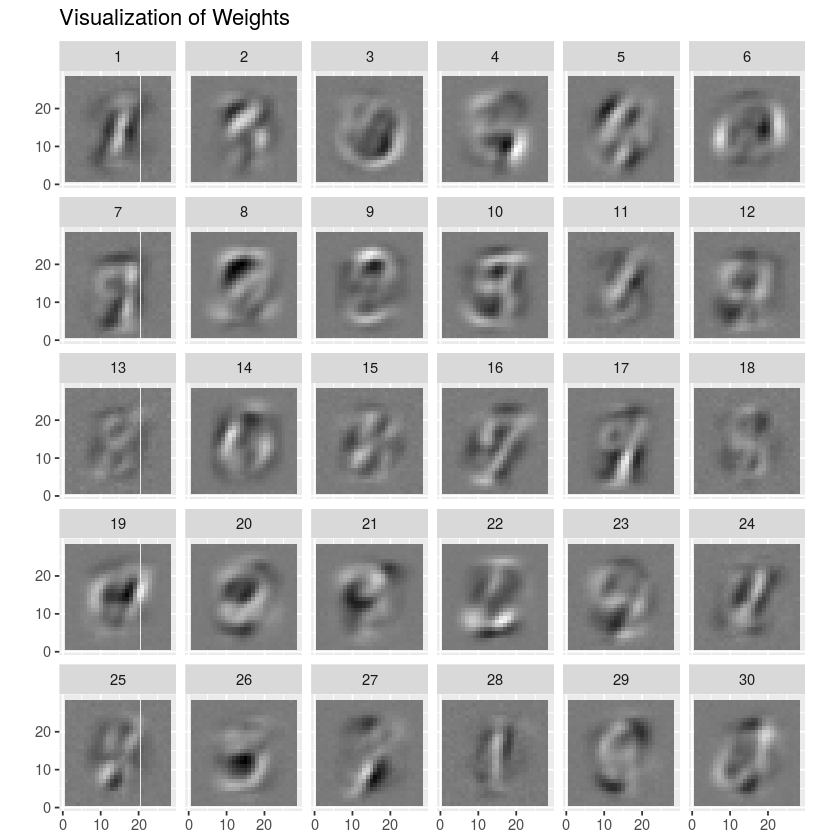

In [17]:
ggplot(data = mw) +
geom_tile(aes(Var2, Var3, fill = value)) +
facet_wrap(~Var1, nrow = 5) +
scale_fill_continuous(low = 'white', high = 'black') +
coord_equal() +
labs(x = NULL, y = NULL, title = "Visualization of Weights") +
theme(legend.position = "none")

### Prediction and Reconstruction

Now, we can select a number in our dataset, pass it through the RBM and see how it is reconstructed versus the real input (how the RBM sees each number).

In [18]:
act.input <- sigmoid_func(training_x %*% rbm$W + rbm$hbias);
rec.input <- act.input %*% t(rbm$W) + rbm$vbias;

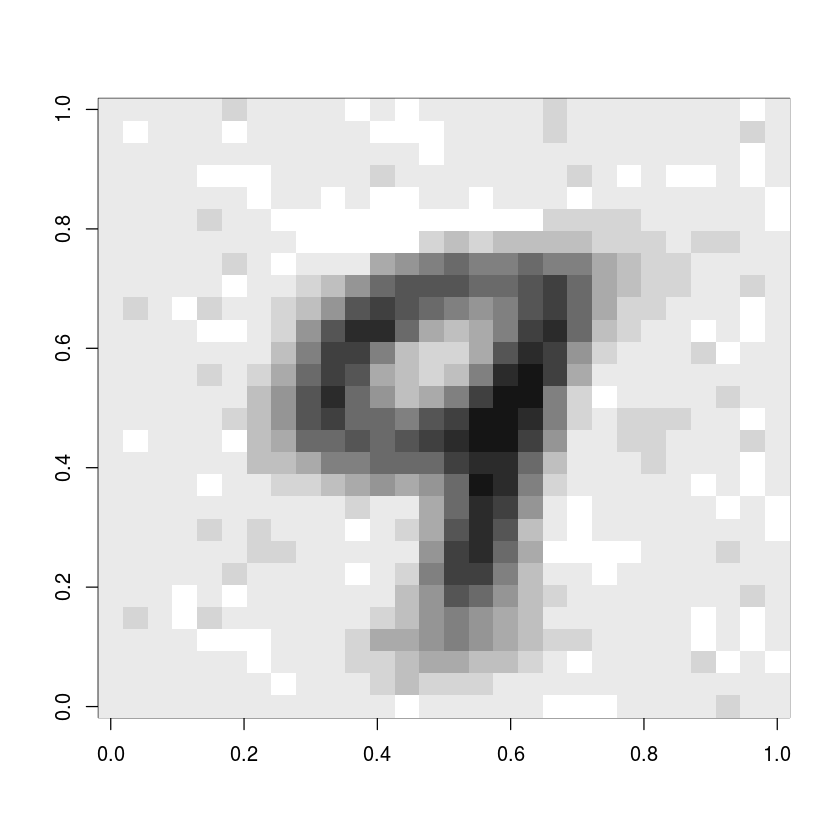

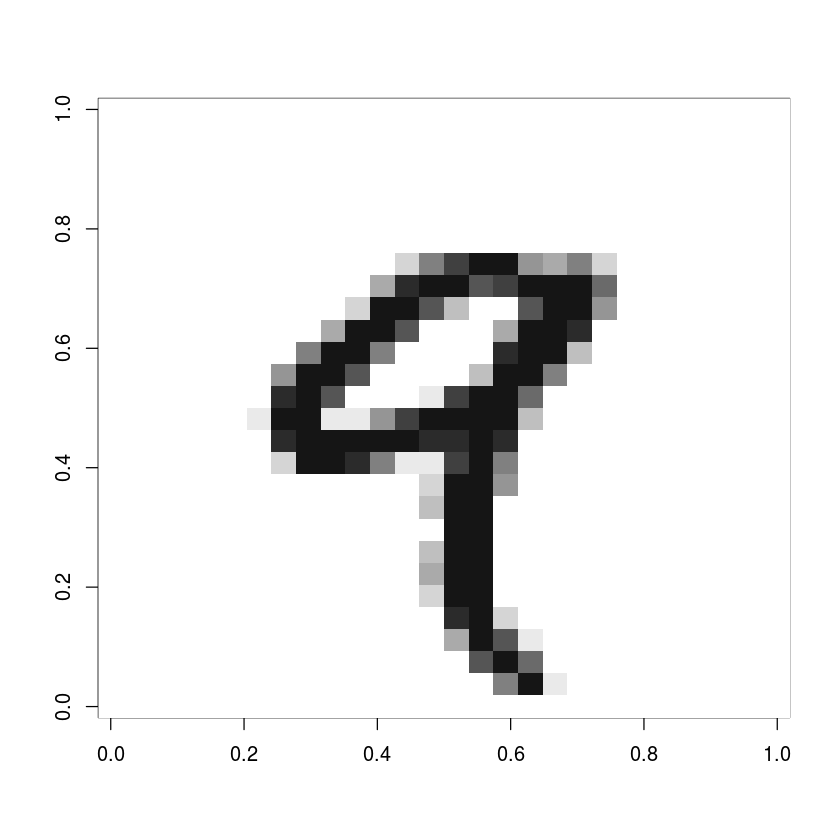

In [19]:
show_digit(as.matrix(rec.input[5,]))
show_digit(as.matrix(training_x[5,]))